In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-w3nm73fc
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-w3nm73fc
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [3]:
%load_ext nvcc_plugin

created output directory at /notebooks/BilateralFiltering/src
Out bin /notebooks/BilateralFiltering/result.out


In [31]:
%%cu

#include "/notebooks/BilateralFiltering/EasyBMP.h"
#include "/notebooks/BilateralFiltering/EasyBMP_BMP.h"
#include "/notebooks/BilateralFiltering/EasyBMP_DataStructures.h"
#include "/notebooks/BilateralFiltering/EasyBMP_VariousBMPutilities.h"
#include "/notebooks/BilateralFiltering/EasyBMP.cpp"
#include <iostream>
#include <vector>
#include <algorithm> 
#include <string>
#include <iomanip>
#include <stdio.h>
#include <chrono>
#include <cuda.h>
#include <cuda_runtime.h>

static const int SIGMA_D = 5;
static const int SIGMA_R = 15;

using namespace std;
using namespace std::chrono;

void GetGConst(float* G_CPU, float sigmaD) {
    int index = 0;
    for (int i = -1; i <= 1; i++)
    {
        for (int j = -1; j <= 1; j++)
        {
            G_CPU[index++] = exp((pow(i, 2) + pow(j, 2)) / (-1*pow(sigmaD,2)));
        }
    }
}

__global__ void kernel(float* G, float* arrayOutput, cudaTextureObject_t texObj, int width, int height, float sigmaR) {

    int index_x = blockIdx.x * blockDim.x + threadIdx.x;
    int index_y = blockIdx.y * blockDim.y + threadIdx.y;
    float a0 = tex2D<float>(texObj, index_x, index_y);
    float hai = 0;
    float ai;
    int index = 0;
    float k = 0;
    if ((index_x < width) && (index_y < height))
    {
        for (int i = index_x - 1; i <= index_x + 1; i++)
        {
            for (int j = index_y-1; j <= index_y + 1; j++)
            {
                ai = tex2D<float>(texObj, i, j);
                float rai = exp((pow(ai - a0, 2.0)) / (pow(sigmaR, 2.0)));
                hai += ai * G[index] * rai;
                k += G[index] * rai;
                ++index;
            }
        }
        arrayOutput[(index_x)  + (index_y)* (width)] = (hai / k);
    }
}

void transformationImageGPU(vector<vector<int>> image, float sigmaR, float* G_GPU, float* h_data) {
    int width = image.size();
    int height = image[1].size();
    
    cudaChannelFormatDesc channelDesc = cudaCreateChannelDesc(32, 0, 0, 0, cudaChannelFormatKindFloat);
    cudaArray_t arrayInput;
    float* arrayOutput;

    cudaMalloc(&arrayOutput, width * height * sizeof(float));
    cudaMallocArray(&arrayInput, &channelDesc, width, height);
    cudaMemcpy2DToArray(arrayInput, 0, 0, h_data, (width) * sizeof(float), (width) * sizeof(float), (height), cudaMemcpyHostToDevice);

    // Работа с текстурами
    struct cudaResourceDesc resDesc;
    memset(&resDesc, 0, sizeof(resDesc));
    resDesc.resType = cudaResourceTypeArray;
    resDesc.res.array.array = arrayInput;

    struct cudaTextureDesc texDesc;
    memset(&texDesc, 0, sizeof(texDesc));
    texDesc.addressMode[0] = cudaAddressModeClamp;
    texDesc.addressMode[1] = cudaAddressModeClamp;
    texDesc.readMode = cudaReadModeElementType;
    texDesc.normalizedCoords = 0;

    // Создание объекта текстур
    cudaTextureObject_t texObj = 0;
    cudaCreateTextureObject(&texObj, &resDesc, &texDesc, NULL);
    
    dim3 BLOCK_SIZE(32, 32, 1);
    dim3 GRID_SIZE(height  / 32 + 1, width/ 32 + 1, 1);

    kernel << <GRID_SIZE, BLOCK_SIZE >> > (G_GPU, arrayOutput, texObj, width, height, sigmaR);

    cudaDeviceSynchronize();
    cudaMemcpy(h_data, arrayOutput, width * sizeof(float) * height, cudaMemcpyDeviceToHost);
    
    cudaDestroyTextureObject(texObj);
    cudaFreeArray(arrayInput);
    cudaFree(arrayOutput);
}

int BilateralFilter(vector<vector<int>> image, int verctical, int gorizontal, float sigmaR, float* G_CPU) {
    float a0 = image[verctical][gorizontal];
    float hai = 0;
    float ai;
    int index = 0;
    float k = 0;
    for (int i = verctical - 1; i <= verctical + 1; i++)
    {
        for (int j = gorizontal - 1; j <= gorizontal + 1; j++)
        {
            ai = image[i][j];
            float rai = exp((pow(ai - a0, 2.0)) / (pow(sigmaR, 2.0)));
            hai += ai * G_CPU[index] * rai;
            k += G_CPU[index] * rai;
            ++index;
        }
    }
    return (int)(hai / k);
}

vector<vector<int>> transformationImageCPU(vector<vector<int>> image, float sigmaR, float* G_CPU) {
    vector<vector<int>> output(image.size(), vector <int>(image[0].size()));
    for (int i = 1; i < (image.size() - 1); i++)
    {
        for (int j = 1; j < (image[0].size() - 1); j++)
        {
            output[i][j] = BilateralFilter(image, i, j, sigmaR, G_CPU);
        }
    }
    return output;
}

int main(void)
{
    SetEasyBMPwarningsOff();
    BMP Input;
    Input.ReadFromFile("/notebooks/BilateralFiltering/sample_320×213.bmp");
    int width = Input.TellWidth();
    int height = Input.TellHeight();
    
    cout << "Image width - " << width << endl;
    cout << "Image height - " << height << endl;
    
    vector<vector<int>> a(width + 2, vector <int>(height + 2));
    
    float* h_data = (float*)malloc(width * height * sizeof(float));
    float* G_CPU = (float*)malloc(9 * sizeof(float));
    float* G_GPU;

    GetGConst(G_CPU, SIGMA_D);
    
    cudaMalloc(&G_GPU, 9 * sizeof(float));
    cudaMemcpy(G_GPU, G_CPU, 9 * sizeof(float), cudaMemcpyHostToDevice);
    
    // Создаем массив векторов цвета
    
    for (int j = 0; j < height; j++)
    {
        for (int i = 0; i < width; i++)
        {
            int temp = (int)floor(0.3 * Input(i, j)->Red + 0.59 * Input(i, j)->Green + 0.11 * Input(i, j)->Blue);
            a[i + 1][j + 1] = temp;
            h_data[i * height + j] = temp;
        }
    }

    for (size_t j = 1; j < height - 1; j++)
    {
        a[0][j] = a[1][j];
        a[width - 1][j] = a[width - 2][j];
    }
    for (size_t i = 1; i < width - 1; i++)
    {
        a[i][0] = a[i][1];
        a[i][height - 1] = a[i][height - 2];
    }
    
    a[0][0] = a[1][1];
    a[0][height - 1] = a[1][height - 2];
    a[width - 1][0] = a[width - 2][1];
    a[width - 1][height - 1] = a[width - 2][height - 2];
    
    // Обработка посредством GPU
    
    auto startGPU = high_resolution_clock::now(); 
    transformationImageGPU(a, SIGMA_R, G_GPU, h_data);
    auto stopGPU = high_resolution_clock::now();
    auto durationGPU = duration_cast<milliseconds>(stopGPU - startGPU);
    
    // Обработка посредством CPU
    
    auto startCPU = high_resolution_clock::now();  
    a = transformationImageCPU(a, SIGMA_R, G_CPU);
    auto stopCPU = high_resolution_clock::now();
    auto durationCPU = duration_cast<milliseconds>(stopCPU - startCPU);
    
    // Вывод результата
    
    cout << "GPU результат - " << durationGPU.count() << " миллисекунд" << endl;
    cout << "CPU результат - " << durationCPU.count() << " миллисекунд" << endl;
    
    // Сохранение получившегося изображения
    
    BMP OutputGPU;
    OutputGPU.ReadFromFile("/notebooks/BilateralFiltering/sample_320×213.bmp");
    for (int j = 0; j < height; j++)
    {
        for (int i = 0; i < width; i++)
        {
            ebmpBYTE color = (ebmpBYTE)h_data[i*height + j];
            OutputGPU(i, j)->Red = color;
            OutputGPU(i, j)->Green = color;
            OutputGPU(i, j)->Blue = color;
        }
    }
    OutputGPU.WriteToFile("/notebooks/BilateralFiltering/outputGPU.bmp");

    BMP OutputCPU;
    OutputCPU.ReadFromFile("/notebooks/BilateralFiltering/sample_320×213.bmp");
    for (int j = 0; j < height; j++)
    {
        for (int i = 0; i < width; i++)
        {
            ebmpBYTE color = (ebmpBYTE)a[i + 1][j + 1];
            OutputCPU(i, j)->Red = color;
            OutputCPU(i, j)->Green = color;
            OutputCPU(i, j)->Blue = color;
        }
    }
    OutputCPU.WriteToFile("/notebooks/BilateralFiltering/outputCPU.bmp");
    
    // Освобождение памяти
    free(h_data);
    
    return 0;
}

Image width - 320
Image height - 213
GPU результат - 2 миллисекунд
CPU результат - 6742 миллисекунд



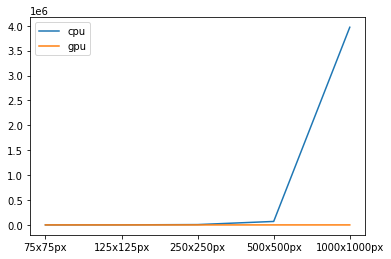

In [15]:
import matplotlib.pyplot as plt

cpu = [91, 814, 6774, 69712, 3969024];
gpu = [5, 5, 9, 9, 11];
size = ['75x75px', '125x125px', '250x250px', '500x500px', '1000x1000px'];

fig, ax = plt.subplots()
ax.plot(size, cpu, label="cpu")
ax.plot(size, gpu, label="gpu")
ax.legend()

plt.show()

In [ ]:
Распараллелено вычисление цвета точки в зависимости от 9 ее ближайших соседей. Алгоритм с применением графического модуля
дает хороший результат скорости вычисления, особенно это заметно для изображений размером от 500x500px. 